In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
sns.set_theme(context='notebook', style='white', font_scale=1.33)

import numpy as np
from os.path import dirname
from pandas import read_csv
import pandas as pd
from numba import njit
from tqdm import tqdm
import json

from os.path import exists
from stan_fit_scripts import fit_ppc


## Analysis

### get data

In [2]:
#set models,session to analyse
stan_models = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6']
stan_versions = ['a','b']
sessions = [1, 2, 3]

In [3]:
# get ppc
all_data = []
for stan_model in stan_models:
    for stan_version in stan_versions:
        for session in sessions:
            path_to_file = os.path.join('stan_results', 'ppc',
                            f'{stan_model}{stan_version}_s{session}_ppc.tsv')
            if exists(path_to_file):
                df = read_csv(path_to_file, sep='\t')
                df['model'] = stan_model
                df['version'] = stan_version
                all_data.append(df)
        
        
all_data = concat(all_data)



In [4]:
all_data.subject.nunique()

110

In [5]:
# get data per model version, a OR b
all_data_a = all_data[all_data.version=='a']
all_data_b = all_data[all_data.version=='b']


### STEP-BY-STEP PLOTS

#### basic compartive plot1: Choice (true vs. predicted) over time - per model& session, split given context.

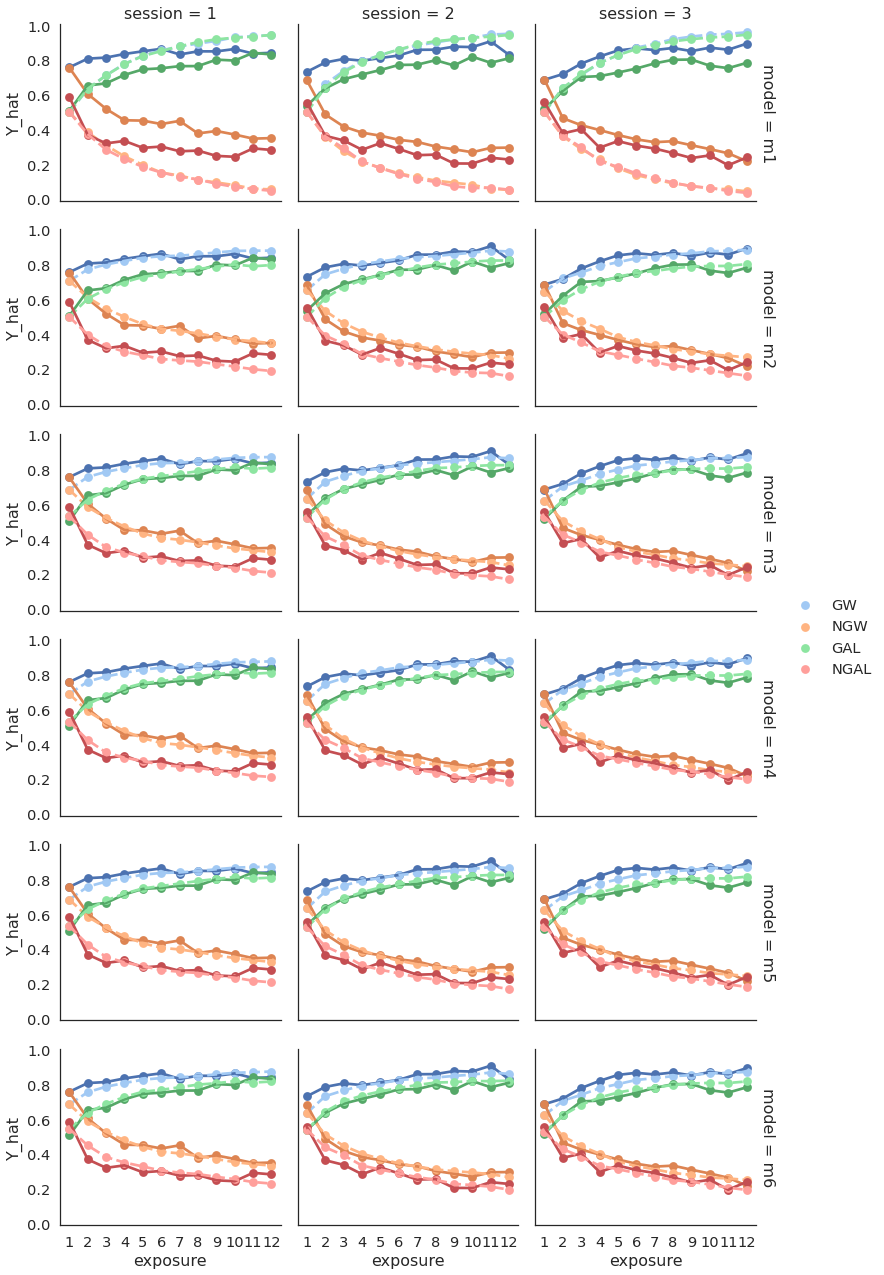

In [6]:
g = sns.FacetGrid(all_data_a, row='model', 
                  row_order=stan_models, col='session', 
                  margin_titles=True,
                  col_order=sessions, aspect=1.25, legend_out=True)

order = np.arange(12) + 1
hue_order = ['GW','NGW','GAL','NGAL']

g.map(sns.pointplot, 'exposure', 'choice', 'robot', 
      palette = sns.color_palette(),
      order=order, hue_order=hue_order, ci=None)

g.map(sns.pointplot, 'exposure', 'Y_hat', 'robot' , 
      palette = sns.color_palette("pastel"),
      order=order, hue_order=hue_order, ci=None, linestyles='--')

g.add_legend()



In [7]:
all_data_456 = all_data[all_data.model.isin(['m4','m5','m6'])]

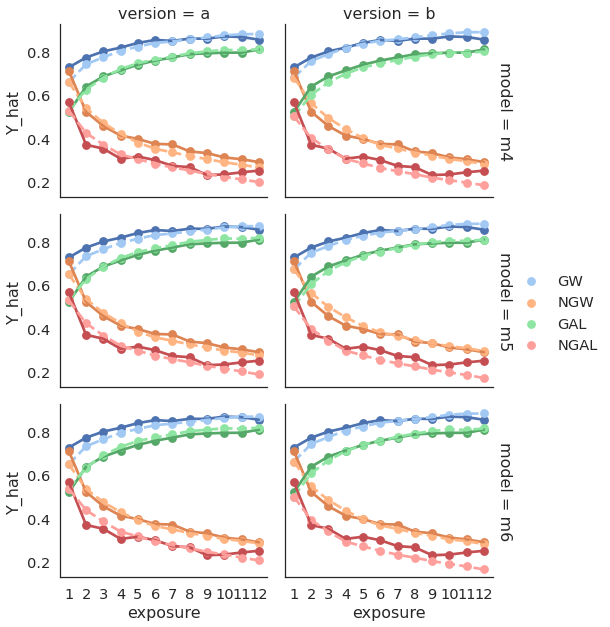

In [8]:

g1 = sns.FacetGrid(all_data_456, row='model', 
                  row_order=['m4','m5','m6'], col='version', 
                  margin_titles=True,
                  col_order=['a','b'], 
                   aspect=1.25, legend_out=True)

order = np.arange(12) + 1
hue_order = ['GW','NGW','GAL','NGAL']

g1.map(sns.pointplot, 'exposure', 'choice', 'robot', 
      palette = sns.color_palette(),
      order=order, hue_order=hue_order, ci=None)

g1.map(sns.pointplot, 'exposure', 'Y_hat', 'robot' , 
      palette = sns.color_palette("pastel"),
      order=order, hue_order=hue_order, ci=None, linestyles='--')

g1.add_legend()



### IDENTITY PLOTS

#### basic compartive plot2: True choice vs. predicted choice - per model, split given context.

In [9]:
gb_choice_a = all_data_a.groupby(['model','version','session','subject','robot']).\
            agg({'choice':'mean', 'Y_hat':'mean'}).reset_index()

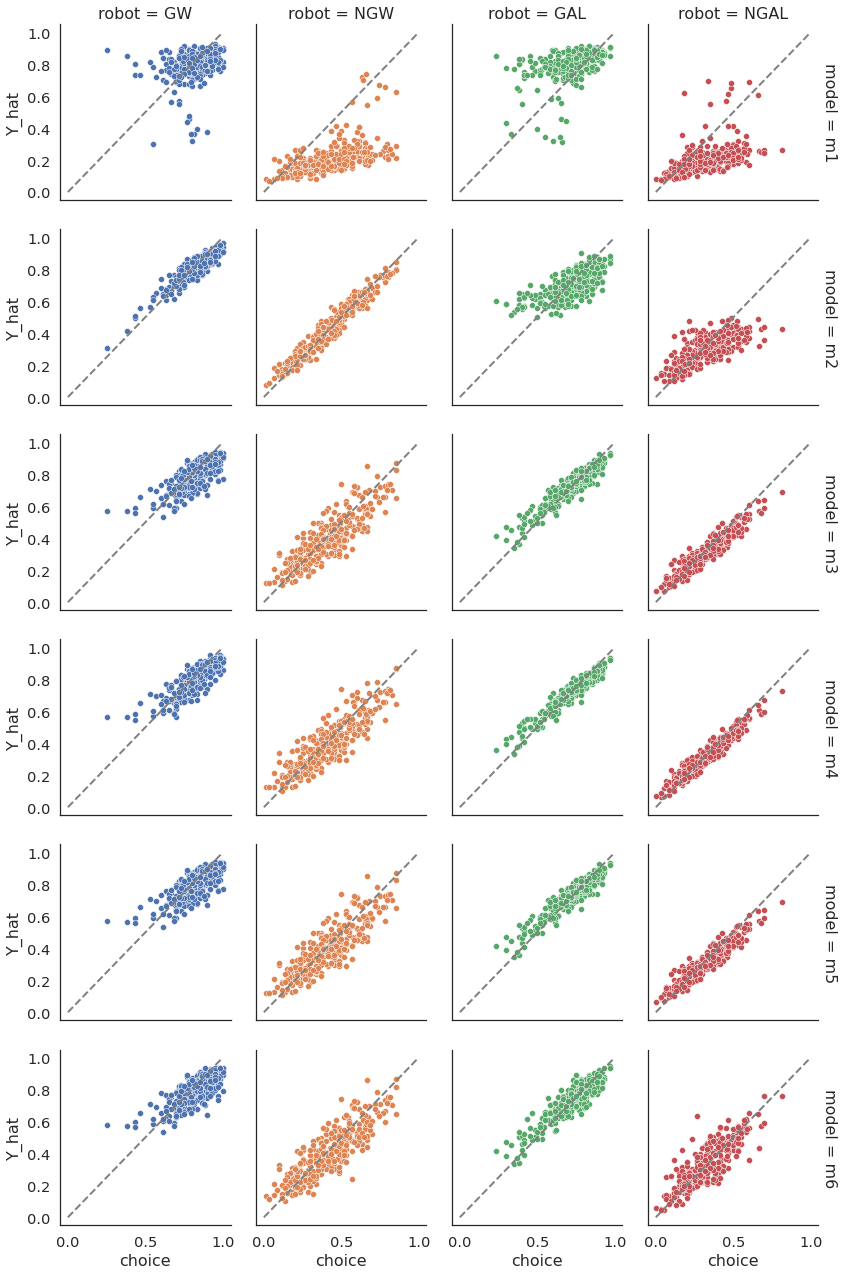

In [10]:

g11 = sns.FacetGrid(gb_choice_a, row = 'model', hue='robot', 
                   hue_order=hue_order, margin_titles=True,
                  row_order = stan_models, col = 'robot', 
                  col_order = ['GW','NGW','GAL','NGAL'], 
                  palette = sns.color_palette())

g11.map(sns.scatterplot, 'choice', 'Y_hat',  )


for ax in g11.axes.ravel():
    ax.plot([0,1], [0,1],
           color='grey', 
           linestyle='--',
           linewidth = 2)



In [11]:
## no beta go

In [12]:
gb_choice_456b = all_data_456.groupby(['model','version','session','subject','robot']).\
            agg({'choice':'mean', 'Y_hat':'mean'}).reset_index()

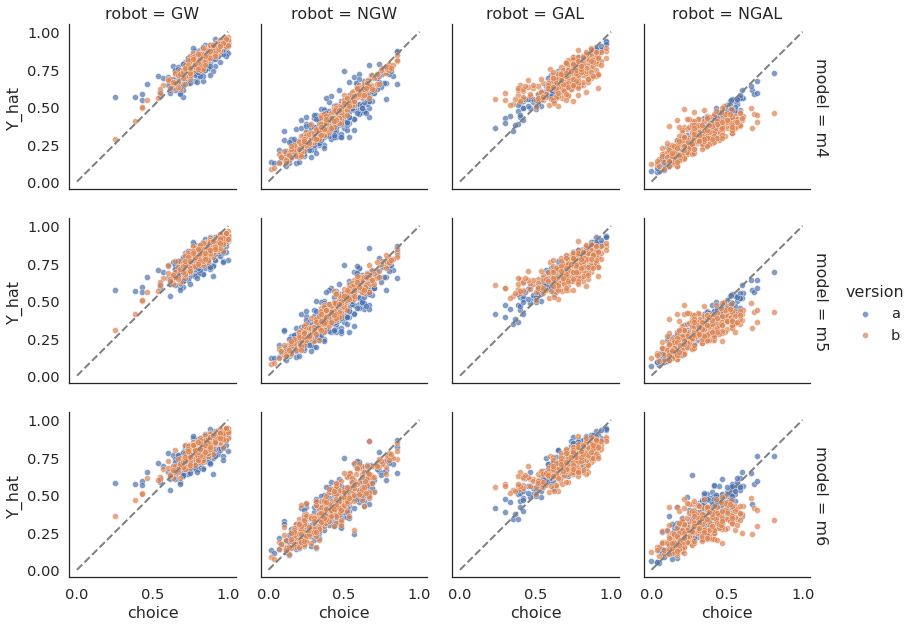

In [13]:

g14 = sns.FacetGrid(gb_choice_456b, row = 'model', hue='version', 
                   hue_order = ['a','b'], margin_titles=True,
                  row_order = ['m4','m5','m6'], col = 'robot', 
                  col_order = ['GW','NGW','GAL','NGAL'], 
                  palette = sns.color_palette())

g14.map(sns.scatterplot, 'choice', 'Y_hat',  alpha=.7)


for ax in g14.axes.ravel():
    ax.plot([0,1], [0,1],
           color='grey', 
           linestyle='--',
           linewidth = 2)

g14.add_legend()


In [14]:
all_data['acc_hat'] = (all_data.Y_hat.round() == all_data.correct) == all_data.accuracy

In [15]:
gb_acc = all_data.groupby(['model','session','subject','robot']).\
            agg({'accuracy':'mean', 'acc_hat':'mean'}).reset_index()

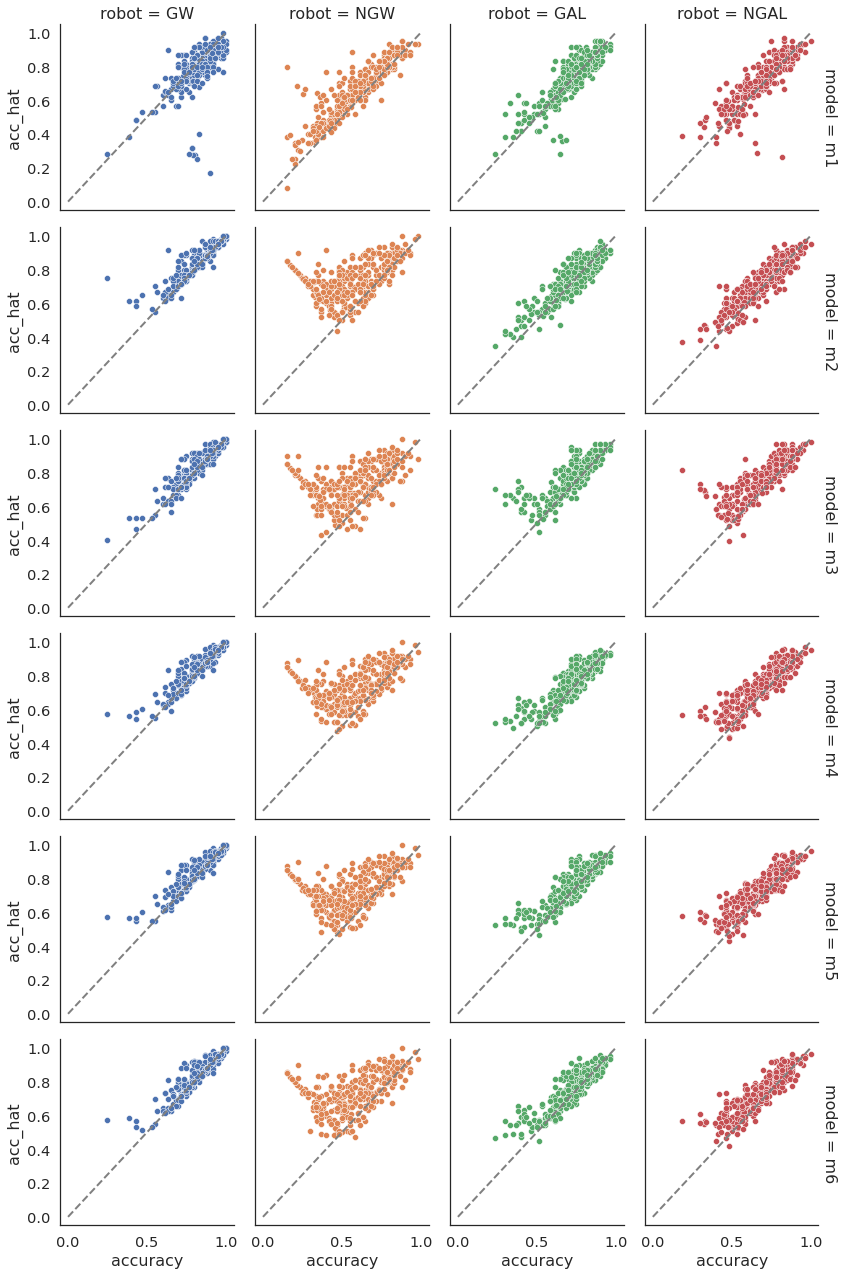

In [16]:
g2 = sns.FacetGrid(gb_acc, row = 'model', hue='robot', 
                   hue_order=hue_order, margin_titles=True,
                  row_order = stan_models, col = 'robot', 
                  col_order = ['GW','NGW','GAL','NGAL'], 
                  palette = sns.color_palette())

g2.map(sns.scatterplot, 'accuracy', 'acc_hat')


for ax in g2.axes.ravel():
    ax.plot([0,1], [0,1],
           color='grey', 
           linestyle='--',
           linewidth = 2)

### MODEL COMPARISON 

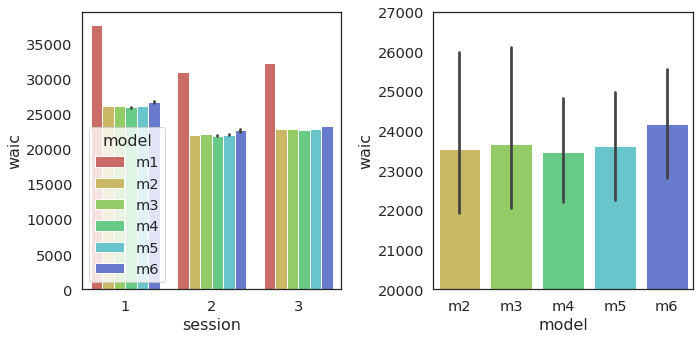

In [17]:
gb_waic = all_data.groupby(['model','version','session']).waic.sum().reset_index()
gb_waic.waic = gb_waic.waic*-2


f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

g3a = sns.barplot(x='session', y='waic', 
                  hue='model', data=gb_waic, ax=ax1,
                 palette = sns.color_palette("hls", 8))

g3b = sns.barplot(x='model', y='waic', 
                  palette = sns.color_palette("hls", 8)[1:],
                  data=gb_waic[gb_waic.model!='m1'], ax=ax2)

g3b.set_ylim(20000, 27000)
plt.tight_layout()

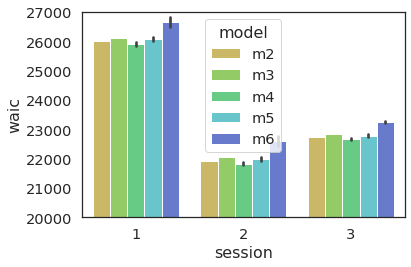

In [18]:


g3b = sns.barplot(x='session', hue='model' ,y='waic', 
                  palette = sns.color_palette("hls", 8)[1:],
                  data=gb_waic[gb_waic.model!='m1'])

g3b.set_ylim(20000, 27000)
plt.tight_layout()

In [19]:
all_data.groupby('session').nunique()['subject']

session
1    110
2     97
3     99
Name: subject, dtype: int64

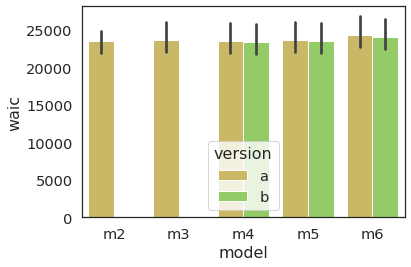

In [31]:
g3c = sns.barplot(x='model', hue='version' ,y='waic', 
                  palette = sns.color_palette("hls", 8)[1:],
                  data=gb_waic[gb_waic.model!='m1'])

g3b.set_ylim(20000, 27000)
plt.tight_layout()

In [20]:
## waic w sd

results_mu = np.zeros((6,6))
results_sd = np.zeros((6,6))

from itertools import combinations

for a, b in list(combinations(stan_models, 2)):
    
    ## Load data.
    df1 = all_data[all_data.model==a]
    df2 = all_data[all_data.model==b]

    arr = -2 * (df2.waic - df1.waic)

    ## Compute stats.
    N = len(df1)
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)

    print(f'{b} - {a}: %0.1f (%0.1f)' %(mu, se))

    results_mu[int(a[1])-1, int(b[1])-1] = mu
    results_sd[int(a[1])-1, int(b[1])-1] = se
    
# rule of thumb, mu>4*se for significance

## model 4 seems to perfrom best

m2 - m1: -30048.7 (491.4)
m3 - m1: -29677.8 (490.9)
m4 - m1: -175789.9 (647.5)
m5 - m1: -173162.6 (646.7)
m6 - m1: -163389.5 (650.3)
m3 - m2: 370.9 (91.8)
m4 - m2: -1571.2 (323.5)
m5 - m2: 1056.0 (322.4)
m6 - m2: 10829.1 (335.1)
m4 - m3: -3692.0 (326.4)
m5 - m3: -1064.8 (325.3)
m6 - m3: 8708.3 (336.8)
m5 - m4: 884.8 (67.4)
m6 - m4: 4209.8 (119.3)
m6 - m5: 3325.0 (97.8)


In [29]:
# im = plt.imshow(results_mu[1:, 1:], cmap="RdBu")
# plt.xticks(np.arange(len(stan_models[1:])), labels=stan_models[1:])
# plt.yticks(np.arange(len(stan_models[1:])), labels=stan_models[1:])


# plt.show()

In [28]:
## waic w sd - VERSION

results_mu = np.zeros((6,6))
results_sd = np.zeros((6,6))

from itertools import combinations

for a, b in list(combinations(['a','b'], 2)):
    for mod in stan_models[3:]:
        ## Load data.
        df1 = all_data[(all_data.version==a) & (all_data.model==mod)]
        df2 = all_data[(all_data.version==b) & (all_data.model==mod)]

        arr = -2 * (df2.waic - df1.waic)

        ## Compute stats.
        N = df1.subject.nunique()
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(N)
        print(mod)
        print(f'{b} - {a}: %0.1f (%0.1f)' %(mu, se))

## version b seems to perfrom best

m4
b - a: -335.3 (3.5)
m5
b - a: -374.1 (3.6)
m6
b - a: -727.6 (4.3)


In [23]:
## waic w sd - SESSION

# results_mu = np.zeros((18,18))
# results_sd = np.zeros((18,18))

from itertools import combinations

m1='m4'
for m2 in list(stan_models):
    for s1 in [1,2,3]:
    
        ## Load data.
        df1 = all_data[(all_data.model=='m4') & (all_data.session==s1)]
        df2 = all_data[(all_data.model==m2) & (all_data.session==s1)]

        arr = -2 * (df2.waic - df1.waic)

        ## Compute stats.
        N = len(df1)
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(N)

        print(f'{m2}_s{s1} - {m1}_s{s1}: %0.1f (%0.1f)' %(mu, se))

# accross all sessions model 4 performs best

m1_s1 - m4_s1: 23357.5 (418.6)
m1_s2 - m4_s2: 18099.2 (391.1)
m1_s3 - m4_s3: 19155.5 (401.1)
m2_s1 - m4_s1: 176.7 (65.5)
m2_s2 - m4_s2: 189.7 (65.9)
m2_s3 - m4_s3: 148.4 (64.9)
m3_s1 - m4_s1: 426.7 (65.1)
m3_s2 - m4_s2: 477.1 (64.5)
m3_s3 - m4_s3: 352.7 (63.8)
m4_s1 - m4_s1: 0.0 (0.0)
m4_s2 - m4_s2: 0.0 (0.0)
m4_s3 - m4_s3: 0.0 (0.0)
m5_s1 - m4_s1: 303.0 (39.8)
m5_s2 - m4_s2: 330.8 (42.3)
m5_s3 - m4_s3: 251.0 (34.1)
m6_s1 - m4_s1: 1502.5 (67.6)
m6_s2 - m4_s2: 1547.7 (74.1)
m6_s3 - m4_s3: 1159.6 (64.6)


In [44]:
## waic w sd



from itertools import combinations

for m in ['m4','m5','m6']:
    for v in ['a','b']:
    
        ## Load data.
        df1 = all_data[(all_data.model=='m4') & (all_data.version=='b')]
        df2 = all_data[(all_data.model==m) & (all_data.version==v)]

        arr = -2 * (df2.waic - df1.waic)

        ## Compute stats.
        N = len(df1)
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(N)

        print(f'{m}_{v} - m4_b: %0.1f (%0.1f)' %(mu, se))


## m4b is better than any other model version  

m4_a - m4_b: 335.3 (89.4)
m4_b - m4_b: 0.0 (0.0)
m5_a - m4_b: 797.1 (101.0)
m5_b - m4_b: 423.0 (47.7)
m6_a - m4_b: 2636.3 (127.3)
m6_b - m4_b: 1908.7 (84.2)


In [24]:
## m2 vs m3

In [25]:
## get subejecst with high b-go

with open('analysis_arrays/above_med_go_subjects.npy', 'rb') as f:
    above_med_go_subjects = np.load(f)
above_med_go_subjects = np.array(above_med_go_subjects,dtype=int) 

above_med_go_subjects_ids = np.array(list(set(all_data.subject)))[above_med_go_subjects-1]

# get ppc for top beta go 
def get_top_beta_go (row):
    if any(sb in row.subject for sb in above_med_go_subjects_ids):
        return True
    return False

all_data['above_med_beta_go'] = all_data.apply (lambda row: get_top_beta_go(row), axis=1)


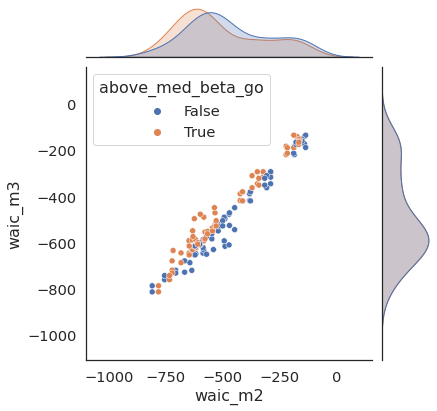

In [26]:

m2_waic = all_data[all_data.model=='m2'].groupby(['model','session','exposure','above_med_beta_go']).waic.sum().reset_index()
m3_waic = all_data[all_data.model=='m3'].groupby(['model','session','exposure','above_med_beta_go']).waic.sum().reset_index()

gb_waic1 = pd.merge(m2_waic[['session','exposure','waic','above_med_beta_go']],
         m3_waic[['session','exposure','waic']], 
         on=['session','exposure'], suffixes=('_m2', '_m3'))


ax1 = sns.jointplot(x='waic_m2',
                    y='waic_m3', 
                    hue='above_med_beta_go',
                   data=gb_waic1,
                   )
